In [36]:
import multiresolutionimageinterface as mir
import openslide
import numpy as np
import skimage
import matplotlib.pyplot as plt
import math

In [34]:
def mask_percent(np_img):
  """
  Determine the percentage of a NumPy array that is masked (how many of the values are 0 values).

  Args:
    np_img: Image as a NumPy array.

  Returns:
    The percentage of the NumPy array that is masked.
  """
  if (len(np_img.shape) == 3) and (np_img.shape[2] == 3):
    np_sum = np_img[:, :, 0] + np_img[:, :, 1] + np_img[:, :, 2]
    mask_percentage = 100 - np.count_nonzero(np_sum) / np_sum.size * 100
  else:
    mask_percentage = 100 - np.count_nonzero(np_img) / np_img.size * 100
  return mask_percentage

In [32]:
def filter_green_channel(np_img, green_thresh=200, avoid_overmask=True, overmask_thresh=90, output_type="bool"):
  """
  Create a mask to filter out pixels with a green channel value greater than a particular threshold, since hematoxylin
  and eosin are purplish and pinkish, which do not have much green to them.

  Args:
    np_img: RGB image as a NumPy array.
    green_thresh: Green channel threshold value (0 to 255). If value is greater than green_thresh, mask out pixel.
    avoid_overmask: If True, avoid masking above the overmask_thresh percentage.
    overmask_thresh: If avoid_overmask is True, avoid masking above this threshold percentage value.
    output_type: Type of array to return (bool, float, or uint8).

  Returns:
    NumPy array representing a mask where pixels above a particular green channel threshold have been masked out.
  """
#   t = Time()

  g = np_img[:, :, 1]
  gr_ch_mask = (g < green_thresh) & (g > 0)
  mask_percentage = mask_percent(gr_ch_mask)
  if (mask_percentage >= overmask_thresh) and (green_thresh < 255) and (avoid_overmask is True):
    new_green_thresh = math.ceil((255 - green_thresh) / 2 + green_thresh)
    print(
      "Mask percentage %3.2f%% >= overmask threshold %3.2f%% for Remove Green Channel green_thresh=%d, so try %d" % (
        mask_percentage, overmask_thresh, green_thresh, new_green_thresh))
    gr_ch_mask = filter_green_channel(np_img, new_green_thresh, avoid_overmask, overmask_thresh, output_type)
  np_img = gr_ch_mask

  if output_type == "bool":
    pass
  elif output_type == "float":
    np_img = np_img.astype(float)
  else:
    np_img = np_img.astype("uint8") * 255

#   util.np_info(np_img, "Filter Green Channel", t.elapsed())
  return np_img

In [46]:
def filter_grays(rgb, tolerance=15, output_type="bool"):
  """
  Create a mask to filter out pixels where the red, green, and blue channel values are similar.

  Args:
    np_img: RGB image as a NumPy array.
    tolerance: Tolerance value to determine how similar the values must be in order to be filtered out
    output_type: Type of array to return (bool, float, or uint8).

  Returns:
    NumPy array representing a mask where pixels with similar red, green, and blue values have been masked out.
  """
#   t = Time()
  (h, w, c) = rgb.shape

  rgb = rgb.astype(np.int)
  rg_diff = abs(rgb[:, :, 0] - rgb[:, :, 1]) <= tolerance
  rb_diff = abs(rgb[:, :, 0] - rgb[:, :, 2]) <= tolerance
  gb_diff = abs(rgb[:, :, 1] - rgb[:, :, 2]) <= tolerance
  result = ~(rg_diff & rb_diff & gb_diff)

  if output_type == "bool":
    pass
  elif output_type == "float":
    result = result.astype(float)
  else:
    result = result.astype("uint8") * 255
#   util.np_info(result, "Filter Grays", t.elapsed())
  return result

In [108]:

slide = openslide.OpenSlide('/media/steer/data1/Images/47.tif')

In [ ]:
208796 / slide.level_dimensions[7][1] * abs(minr- maxr)

In [ ]:
slide.level_count

In [ ]:
slide.dimensions

In [ ]:
slide.level_dimensions

In [109]:
thumb = slide.get_thumbnail(slide.level_dimensions[7])


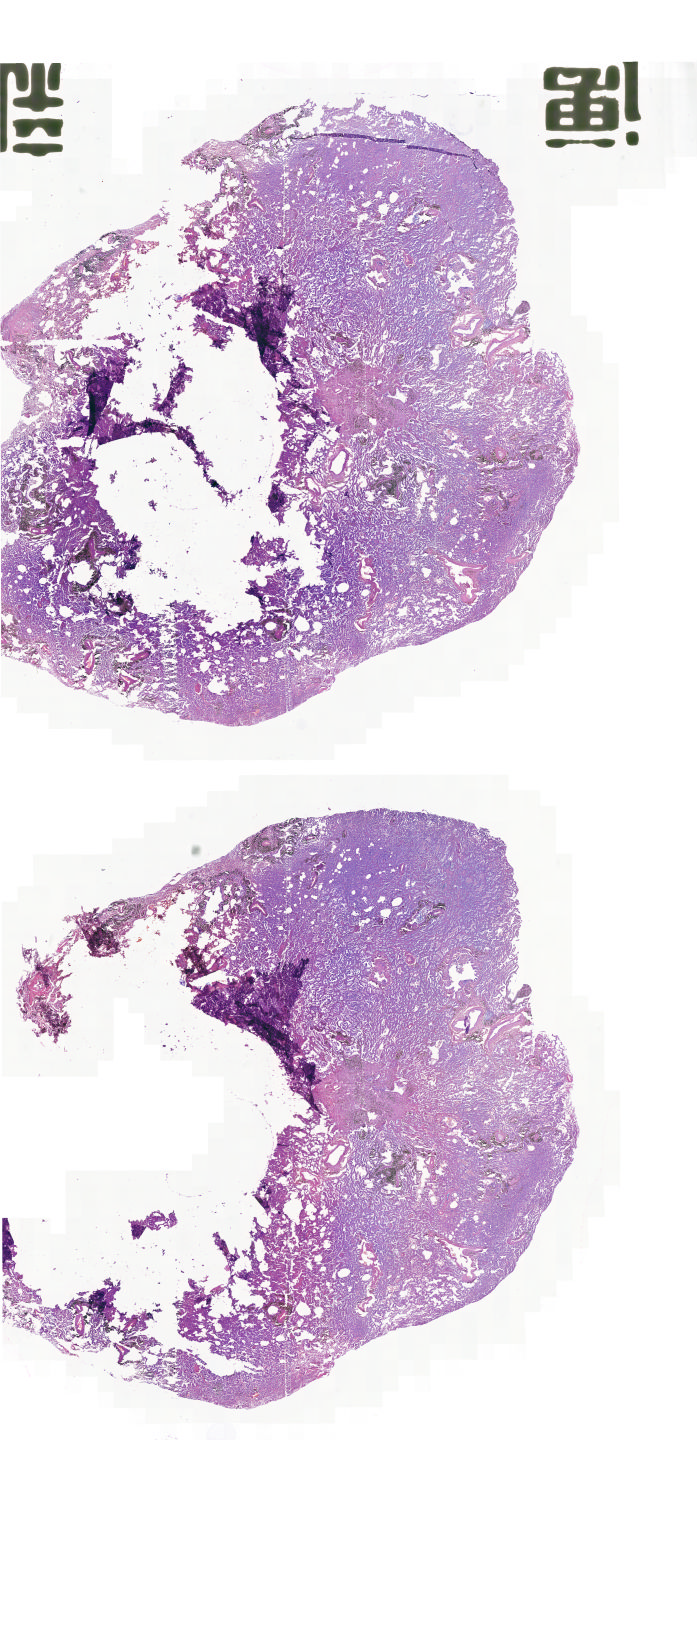

In [110]:
thumb

In [111]:
thumb_rgb = np.asarray(thumb)

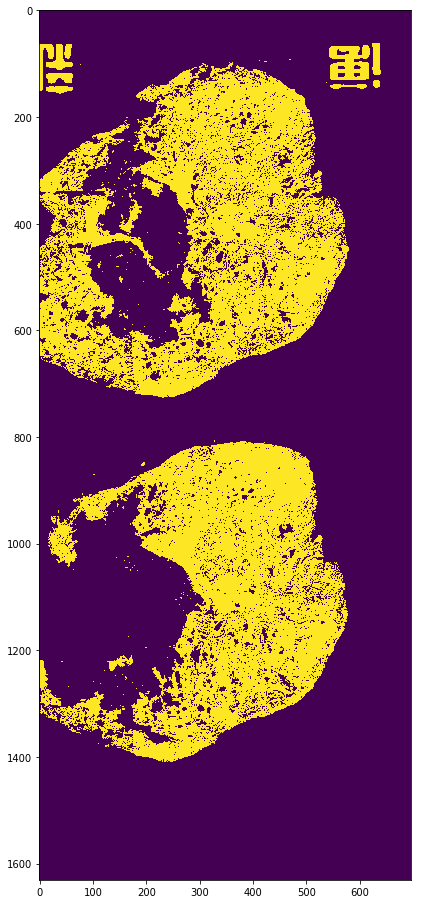

In [112]:
nog = filter_green_channel(thumb_rgb)
plt.figure(figsize=(16,16))
plt.imshow(nog)

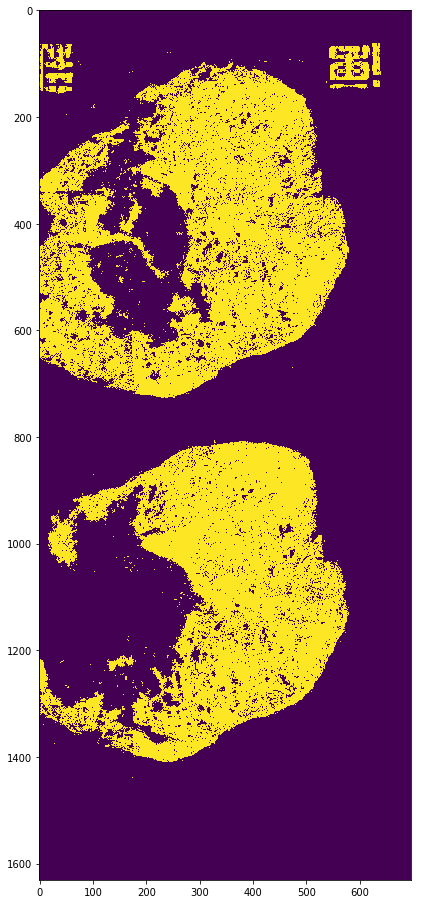

In [115]:
nogr = filter_grays(thumb_rgb)
plt.figure(figsize=(16,16))
plt.imshow(nogr)

In [31]:
thumb_rgb.shape

(1631, 697, 3)

In [116]:
thumb_gray = skimage.color.rgb2gray(np.array(thumb))

In [118]:
coins = 1. - thumb_gray

In [ ]:
np.unique(coins)

Text(0.5, 1.0, 'histogram of grey values')

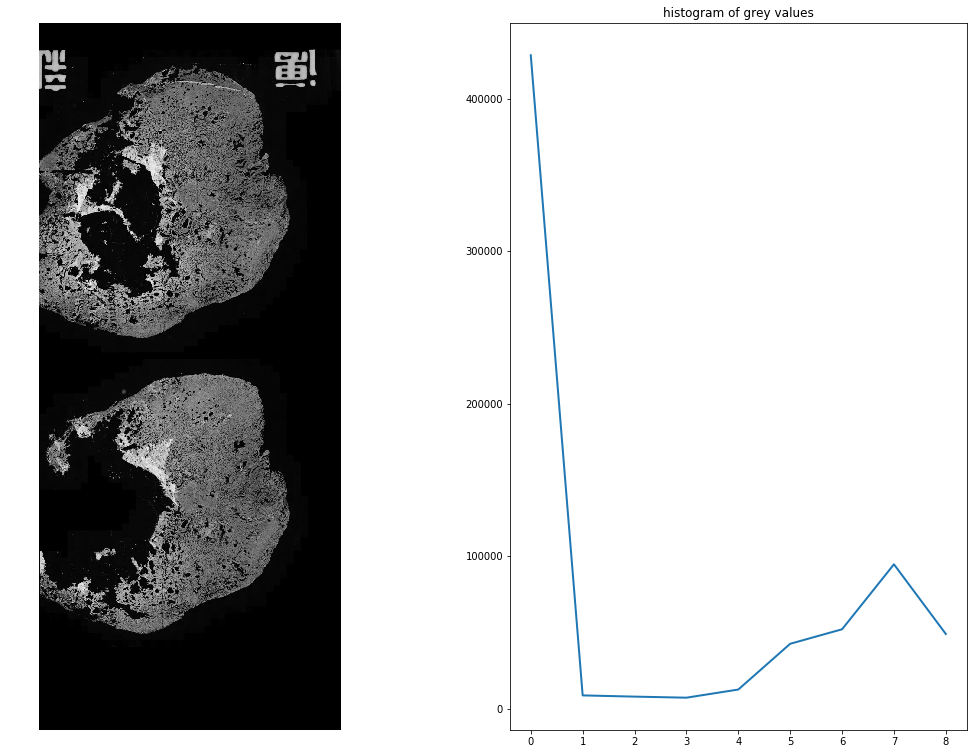

In [119]:
hist = np.histogram(coins * 255., bins=np.arange(0, 10))

plt.figure(figsize=(18, 13))
plt.subplot(121)
plt.imshow(coins, cmap=plt.cm.gray, interpolation='nearest')
plt.axis('off')
plt.subplot(122)
plt.plot(hist[1][:-1], hist[0], lw=2)
plt.title('histogram of grey values')

Text(0.5, 1.0, 'elevation_map')

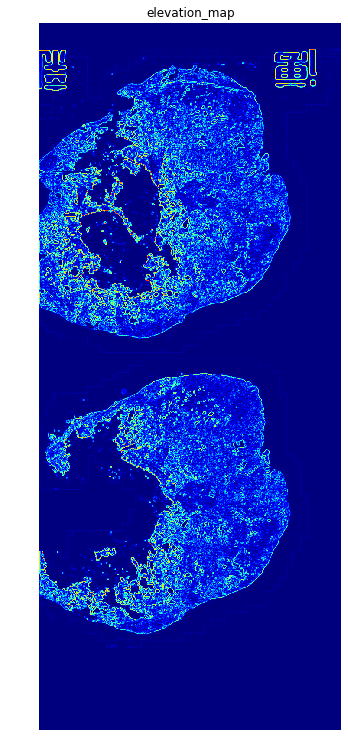

In [120]:
from skimage.filters import sobel

elevation_map = sobel(coins)

plt.figure(figsize=(14, 13))
plt.imshow(elevation_map, cmap=plt.cm.jet, interpolation='nearest')
plt.axis('off')
plt.title('elevation_map')

Text(0.5, 1.0, 'markers')

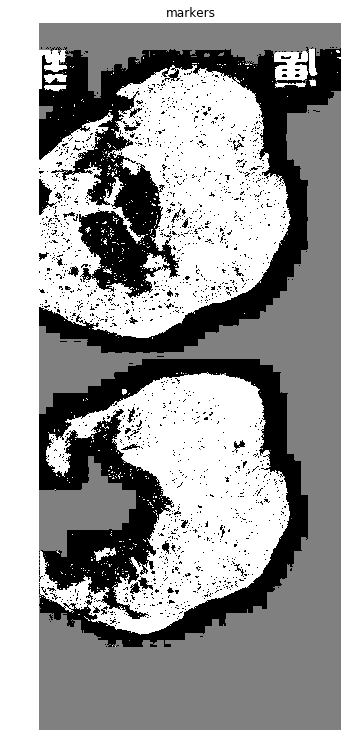

In [121]:
markers = np.zeros_like(coins)
markers[coins <= 1/255.] = 1
markers[coins >= 15/255.] = 2

plt.figure(figsize=(14, 13))
plt.imshow(markers, interpolation='nearest', cmap=plt.cm.gray)
plt.axis('off')
plt.title('markers')

In [53]:
from skimage import morphology, measure

Text(0.5, 1.0, 'segmentation')

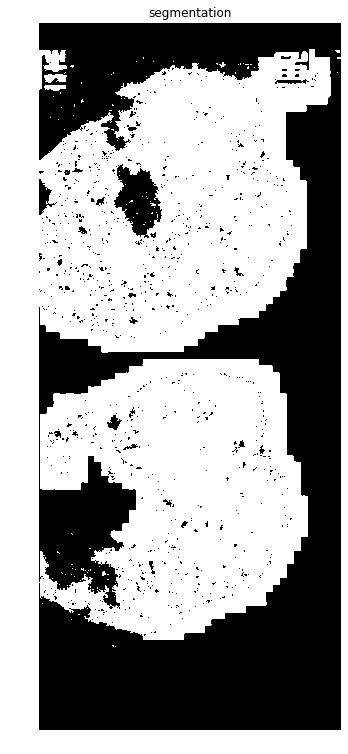

In [124]:
from skimage.morphology import watershed
segmentation = watershed(elevation_map, markers)
# segmentation = morphology.remove_small_objects(segmentation)
plt.figure(figsize=(14, 13))
plt.imshow(segmentation, cmap=plt.cm.gray, interpolation='nearest')
plt.axis('off')
plt.title('segmentation')

In [102]:
np.unique(segmentation), segmentation.max(), segmentation.min()

(array([1, 2], dtype=int32), 2, 1)

True

In [103]:
segmentation = nog & nogr & (segmentation-1)

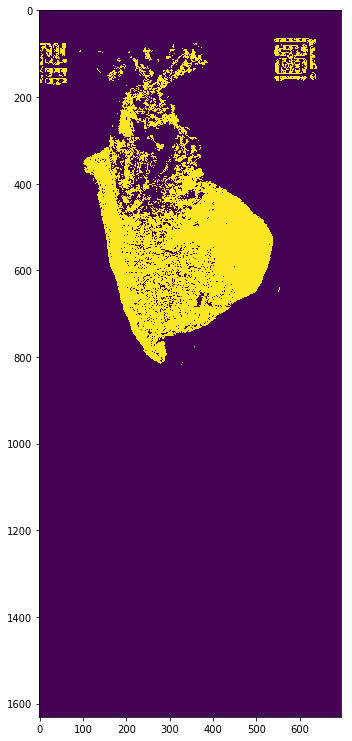

In [104]:
plt.figure(figsize=(14, 13))
plt.imshow(nog&nogr&(segmentation-1))
plt.imshow(segmentation)

In [92]:
np.unique(segmentation)

array([False])

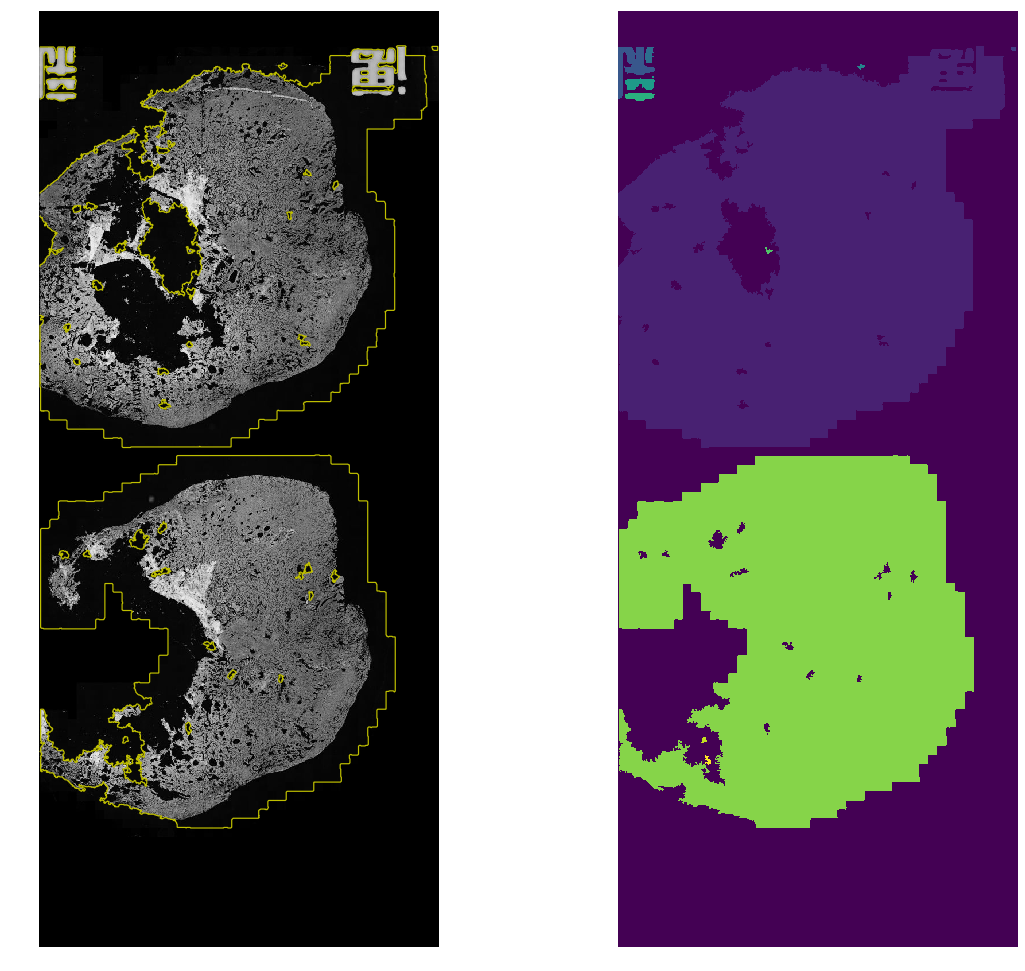

In [125]:
from scipy import ndimage
segmentation = morphology.remove_small_holes(segmentation-1)
segmentation = morphology.remove_small_objects(segmentation)
labeled_coins = measure.label(segmentation)

plt.figure(figsize=(16, 13))
plt.subplot(121)
plt.imshow(coins, cmap=plt.cm.gray, interpolation='nearest')
plt.contour(segmentation, [0.5], linewidths=1.2, colors='y')
plt.axis('off')
plt.subplot(122)
plt.imshow(labeled_coins, interpolation='nearest')
plt.axis('off')
margins = dict(hspace=0.01, wspace=0.01, top=1, bottom=0, left=0, right=1)
plt.subplots_adjust(**margins)

In [126]:
mask = thumb_gray != 1

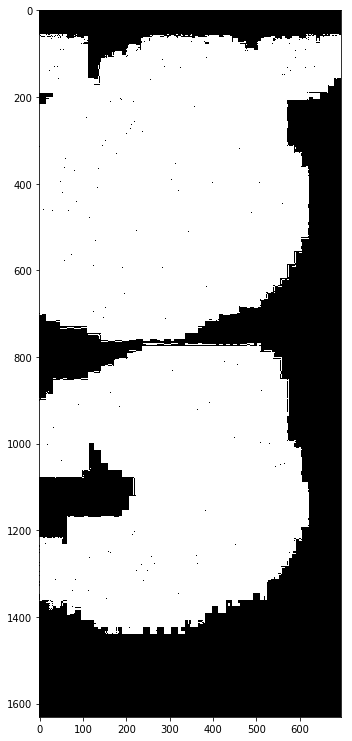

In [127]:
plt.figure(figsize=(14, 13))
plt.imshow(mask, cmap=plt.cm.gray)

In [58]:
from skimage import morphology, measure

In [59]:
np.unique(convx)

array([False,  True])

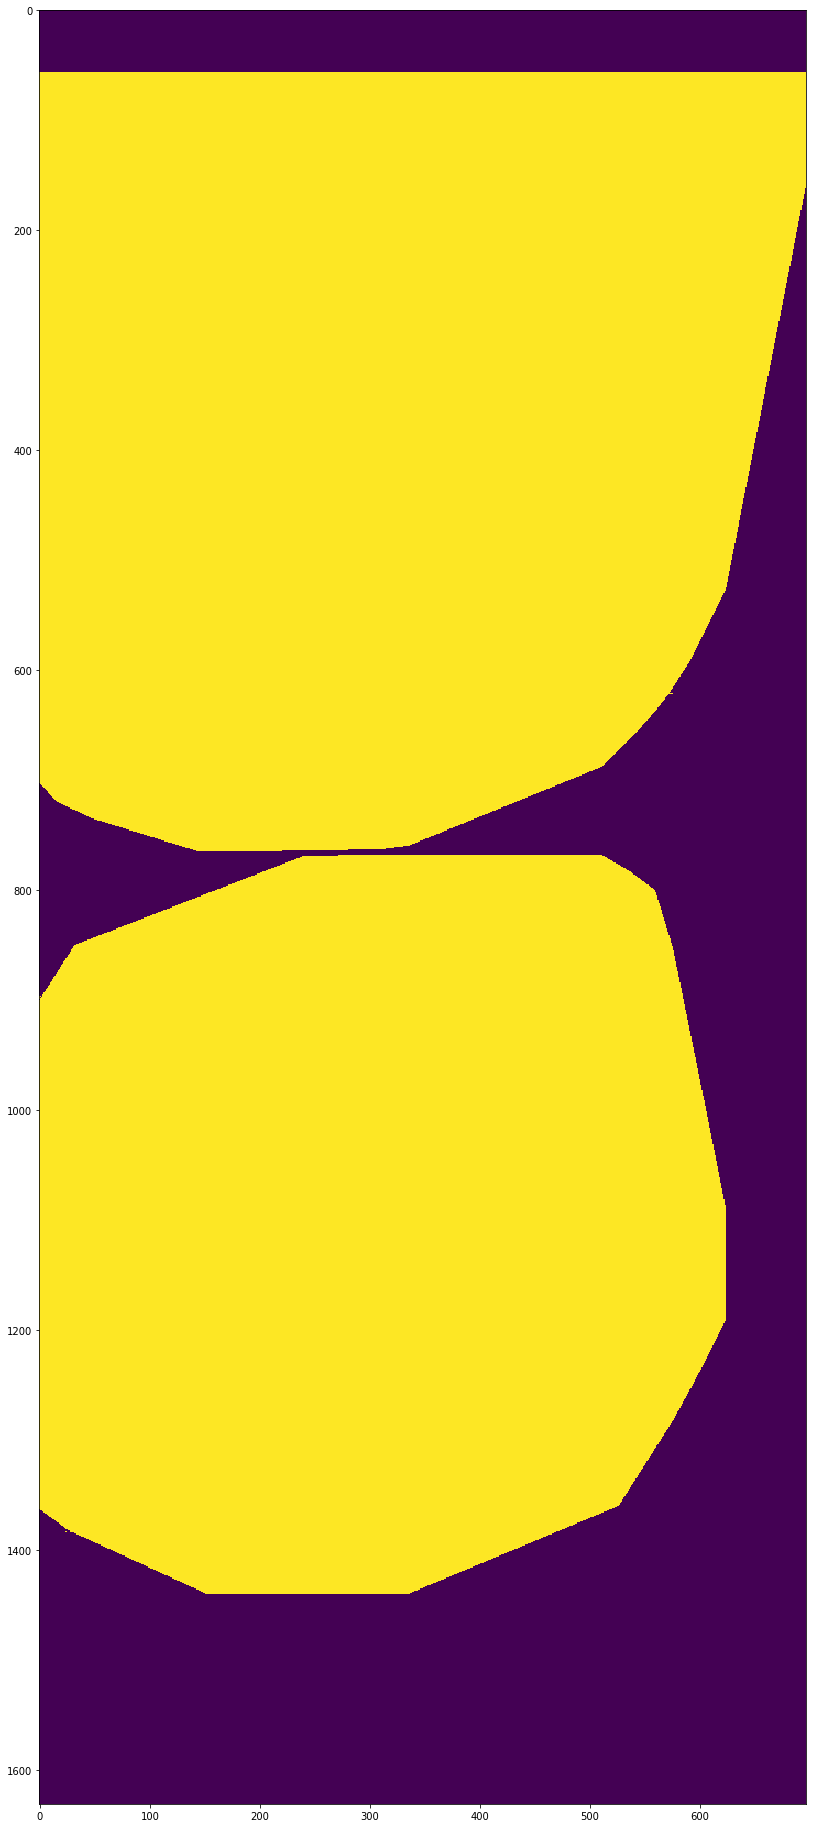

In [128]:
mask = morphology.binary_dilation(mask)
mask = morphology.binary_erosion(mask)
convx = morphology.convex_hull_object(mask)
plt.figure(figsize=(14, 33))
plt.imshow(convx)

In [130]:
mask = morphology.remove_small_holes(convx)
mask = morphology.remove_small_objects(mask)

In [131]:
import matplotlib.patches as mpatches

In [132]:
label_image = measure.label(mask)

In [133]:
image_label_overlay = skimage.color.label2rgb(label_image, image=mask)

(56, 0, 765, 697)
(768, 0, 1440, 624)


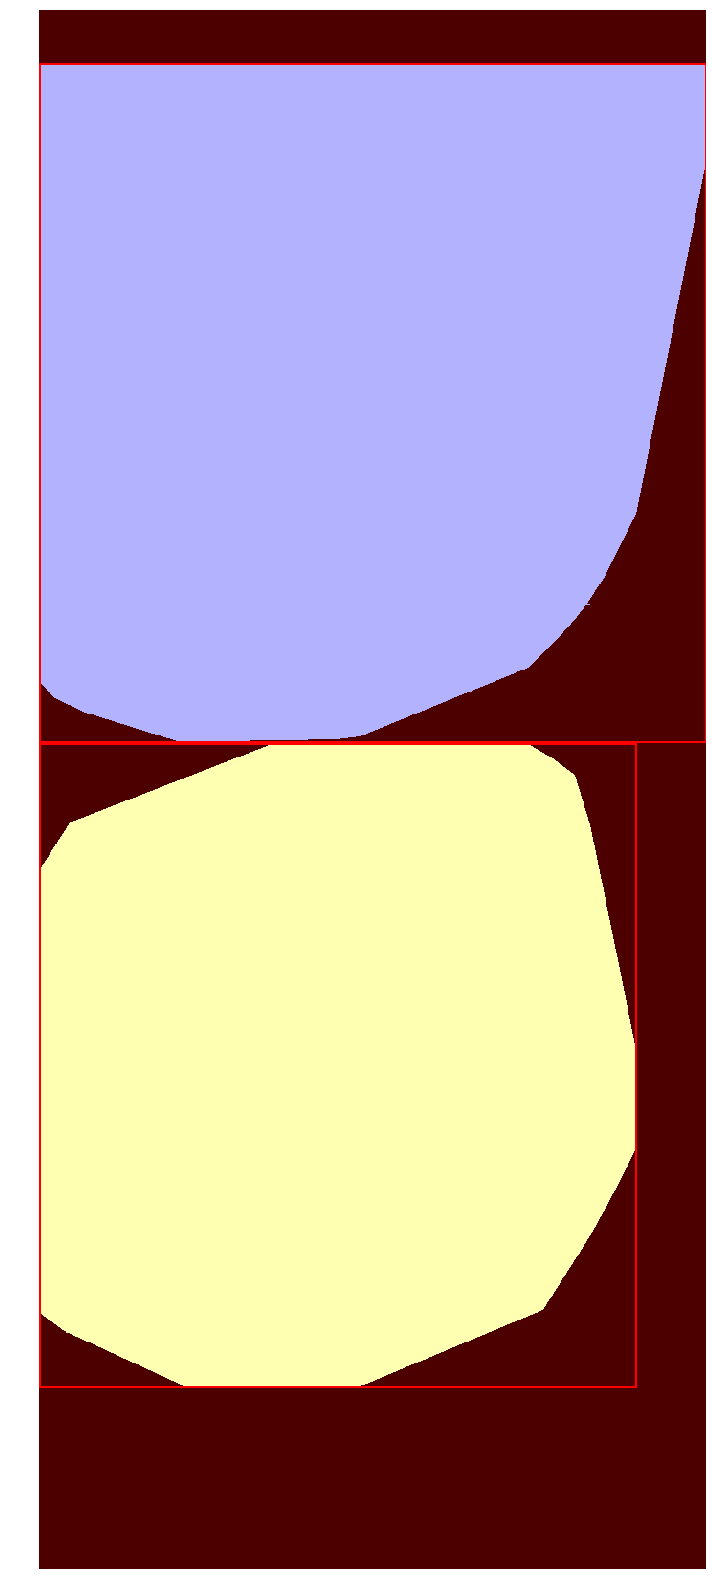

In [134]:
fig, ax = plt.subplots(figsize=(10, 33))
ax.imshow(image_label_overlay)

for region in measure.regionprops(label_image):
    # take regions with large enough areas
    if region.area >= 100:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        print(region.bbox)
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)

ax.set_axis_off()
plt.tight_layout()
plt.show()